In [206]:
import requests, time, pickle, os
import CF_standard_functions as cf_sf # Standard utility functions
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [207]:
# Set these parameters for saving and loading data
output_dir = os.getcwd()
file_name = 'CardData.pkl'
full_file = output_dir+"\\"+file_name

## Get Card Data from Scryfall using the Scryfall API
**Scryfall** is a powerful database and search engin for Magic: The Gathering cards. 
We will use their API to download all cards that have flavor text. Since cards are often reprinted with different flavor text each time, we will import all printed versions of every card that _does_ contain flavor text. 

https://scryfall.com/docs/api

We then convert the data to a pandas dataframe and isolate unique instances of flavor text. Finally we will save a local copy of the data so that we don't have to access the API repeatedly. New cards are only added monthly or so. 



In [208]:
# Scryfall query parameters:
order = "cmc"
# Unique printings of cards that have flavor text, English prints only, and ignoring "funny" cards (like those from the un-sets or holiday cards)
querystring = "has%3Aflavor+unique%3Aprints+%2Dis%3Dfunny+language%3Den&unique=prints"
url = f"https://api.scryfall.com/cards/search?order={order}&q={querystring}"

# First check if data already exists and is "fresh". If so, load it in:
# Here defining fresh as newer than a week
if os.path.isfile(full_file) and cf_sf.file_age_in_hours(full_file) < 24*3 :
    print('Loading data from disk...')
    file = open(full_file, 'rb')
    data = pickle.load(file)
    file.close()
    print('Done!')
else:# Otherwise get the data from Scryfall. This can take a while... 
    sf_response = requests.get(url).json()
    data = sf_response['data']
    curr_page = 1;
    print(f"Page {curr_page}",end='\r')
    while sf_response['has_more']:  
        time.sleep(0.2) # Be polite and patient with the API
        url_next = sf_response['next_page']
        sf_response = requests.get(url_next).json()
        data_new = sf_response['data']
        data = data + data_new
        curr_page += 1 
        print(f"Page {curr_page}",end='\r')
    
    print(f"Loaded {curr_page} pages of cards")
    print("Saving...")
    data = pd.DataFrame(data)
    data.drop_duplicates(subset='flavor_text',inplace=True)
    file = open(full_file,'wb')    
    pickle.dump(data, file)
    file.close()
    print("Done!")
    
nCards = len(data)
print(nCards,"cards in data set")

Loading data from disk...
Done!
20546 cards in data set


### Organize cards by color
In our first task we will classify flavor text by color. For convenience, we will make a new dataframe subsetting only the name, flavortext, and color of monocolored cards.\
To make separating cards by colors easier, we add a Boolean variable to the dataframe for each color.\
We also add a Boolean for whether or not a card is monocolored (not colorless and not multicolored). \
Finally, sort our cards in traditional WUBRG (**W**hite, Bl**u**E, **B**lack, **R**ed, **G**reen) order by setting the _colors_ variable to a categorical value.


In [209]:
data = pd.DataFrame(data)
data.drop_duplicates(subset='flavor_text',inplace=True)

for c in ['W','U','B','R','G']:
    tf = data.colors.apply(lambda x : np.shape(x) != (0,) and np.any(np.isin(x,c)))
    data['is_'+c] = tf

tf = np.sum(data.loc[:][['is_W','is_U','is_B','is_R','is_G']],axis=1) == 1
data['is_monocolor'] = tf

data_monocolor = data.loc[data.is_monocolor][['name','colors','flavor_text']].copy()
data_monocolor['colors'] = data_monocolor.colors.apply(lambda x: ''.join(x)) # Convert from list to string

data_monocolor['colors'] = pd.Categorical(data_monocolor['colors'],ordered=True)
data_monocolor['colors'] = data_monocolor['colors'].cat.reorder_categories(['W','U','B','R','G'])
data_monocolor.sort_values('colors',ascending=True,inplace=True)
data_monocolor
#print(f"Post-trimming: {data_monocolor.shape[0]} unique instances of flavor text on monocolor cards")

C:\Users\gordo\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,colors,flavor_text
14283,Squire,W,"""Of twenty yeer of age he was, I gesse.\nOf hi..."
34523,Miraculous Recovery,W,"""You stop breathing for just a few minutes and..."
10950,Kami of Ancient Law,W,"""Duty and law are the foundation on which civi..."
10933,Justiciar's Portal,W,"With the new guildmaster's innovations, arrest..."
10923,Juniper Order Rootweaver,W,"""What Phyrexia takes, the grace of Freyalise s..."
...,...,...,...
20088,Hungry Spriggan,G,If a spriggan's eyes are larger than its stoma...
34455,Meandering Towershell,G,The wait is proportional to the weight.
11145,Kraul Warrior,G,The insectile kraul lurk in the tunnels below ...
20093,Hunter's Ambush,G,First you lose your enemy's trail. Then you lo...


### Prepare data for classification

For our classifier we need numeric groups, so we will make numeric categories for the colors.

In [210]:
label_map = {'W':0,
             'U':1,
             'B':2,
             'R':3,
             'G':4}
data_monocolor['label'] = data_monocolor['colors'].map(label_map)
data_monocolor.sample(5)

,name,colors,flavor_text,label
9154,Elemental Uprising,G,"""My heart and Zendikar's beat as one. Together...",4
35584,Silverback Ape,G,"His true majesty is not in his silver, but in ...",4
36619,Arcanis the Omnipotent,U,"""Do not concern yourself with my origin, my ra...",1
20396,Jolrael's Centaur,G,"""What need have I for cavalry when I can have ...",4
21370,Minion's Return,B,"As a mortal, Phenax was the first to escape th...",2


### Split data into train and test sets

In [211]:
from sklearn.model_selection import train_test_split

flavor_train, flavor_test, label_train, label_test = train_test_split(
        data_monocolor['flavor_text'], data_monocolor['label'], test_size=0.25, random_state=1)

print('Training set consists of',flavor_train.shape[0],'cards.')
print('Test set consists of',flavor_test.shape[0],'cards.')


Training set consists of 12005 cards.
Test set consists of 4002 cards.


## Design our Model!
- Tokenize the words in flavor text, ignoring terms that are extremeley common and those that only appear 3 or fewer times in the training set.
- Classify the text using an SVM.

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
my_vectorizer = TfidfVectorizer(min_df = 3)
pipe = Pipeline([('vect',my_vectorizer),
               ('clf',LinearSVC())])

pipe = pipe.fit(flavor_train,label_train)

label_predict = pipe.predict(flavor_test)
performance = np.round(sum(label_predict == label_test) / len(label_test) , 3)*100
print('Classifier hit rate is %s%%' % performance)


Classifier hit rate is 50.6%


**Measure performance with a confusion matrix:**

              precision    recall  f1-score   support

           W       0.48      0.50      0.49       847
           U       0.47      0.53      0.50       729
           B       0.50      0.52      0.51       773
           R       0.55      0.49      0.52       851
           G       0.53      0.50      0.51       802

    accuracy                           0.51      4002
   macro avg       0.51      0.51      0.51      4002
weighted avg       0.51      0.51      0.51      4002



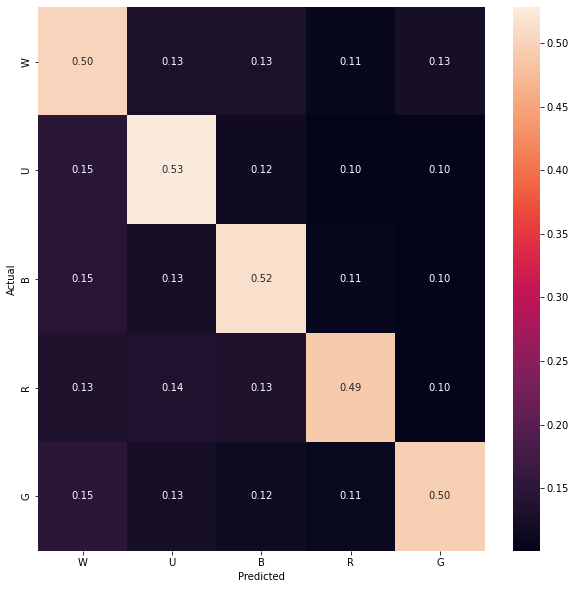

In [213]:
from sklearn import metrics
import seaborn as sns

print(metrics.classification_report(label_test, label_predict,target_names = [str(i) for i in label_map]))

cm = metrics.confusion_matrix(label_test, label_predict,normalize='true',
                              labels=list(label_map.values()))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=[str(i) for i in label_map],yticklabels=[str(i) for i in label_map])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


**Not too shabby!** \
Looks like we do a better job classifying Blue cards and a worse job at Red cards, but only slightly.

We can now write our own flavor text and see what color our model thinks it belongs to.

In [214]:
new_flavor_text = ['Goblins sure do smell bad',
              'Your spell was a mistake and now it is gone',
              'Trees are the most beautiful thing',
              'Death cannot stop the wicked',
              'The angelic choir sings loftily over the clouds',
              '"Some like it hot" -Chandra Nalaar']

new_color_predictions = pipe.predict(new_flavor_text)
# Reverse-lookup color mapping    
for txt,col in zip(new_flavor_text,new_color_predictions):
    print(f"{txt} --> {[str(i) for i in label_map][col]}")

Goblins sure do smell bad --> R
Your spell was a mistake and now it is gone --> U
Trees are the most beautiful thing --> G
Death cannot stop the wicked --> B
The angelic choir sings loftily over the clouds --> W
"Some like it hot" -Chandra Nalaar --> R


**Lets see if we can do better by tokenizing word pairs as well as individual words**

In [215]:
performance = np.round(sum(label_predict == label_test) / len(label_test) , 3)*100
print('Classifier hit rate is %s%%' % performance)
pipe.set_params(vect__ngram_range = (1,2))
pipe.fit(flavor_train,label_train)
color_predict = pipe.predict(flavor_test)


Classifier hit rate is 50.6%


**Not much better. Lets do a more thorough hunt of parameters with a grid search** \
(this takes a long time to run, check the Python kernal for progress updates)

In [59]:
from sklearn.model_selection import GridSearchCV 

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)] ,
    'vect__max_df': [0.8,0.9,0.95,0.99],
    'vect__min_df': [1,2,3],
    'clf__C':       [0.01,0.1,1,10]}
gs = GridSearchCV(pipe, parameters, n_jobs=-1,verbose=2)
gs.fit(flavor_train,label_train)

gs_df = pd.DataFrame.from_dict(gs.cv_results_)

print(gs.best_score_)
print(gs.best_params_)
gs_df.head()

Fitting 5 folds for each of 96 candidates, totalling 480 fits
0.5192003331945023
{'clf__C': 0.1, 'vect__max_df': 0.8, 'vect__min_df': 1, 'vect__ngram_range': (1, 1)}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.402894,0.012971,0.059413,0.002154,0.01,0.8,1,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.461474,0.462307,0.452312,0.460225,0.458559,0.458975,0.003563,77
1,1.424120,0.045235,0.144632,0.020466,0.01,0.8,1,"(1, 2)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.452312,0.452312,0.449813,0.449396,0.438151,0.448397,0.005266,93
2,0.440701,0.011778,0.060011,0.006325,0.01,0.8,2,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.463140,0.465223,0.453561,0.459392,0.459808,0.460225,0.003969,69
3,0.985018,0.082127,0.125630,0.010134,0.01,0.8,2,"(1, 2)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.463973,0.464390,0.449396,0.455643,0.456060,0.457893,0.005653,85
4,0.516515,0.039460,0.078017,0.003348,0.01,0.8,3,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.461474,0.466056,0.453145,0.461474,0.462724,0.460975,0.004259,65


**Plot the relationships between model parameters and model score**

Text(0.5, 0, 'ngram_range_max')

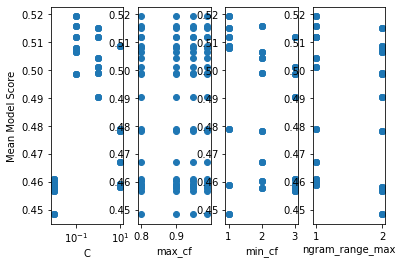

In [89]:
fig,ax = plt.subplots(1,4)
ax[0].scatter(gs_df.param_clf__C,gs_df.mean_test_score)
ax[0].set_xscale('log')
ax[0].set_ylabel('Mean Model Score')
ax[0].set_xlabel('C')
ax[1].scatter(gs_df.param_vect__max_df,gs_df.mean_test_score)
ax[1].set_xlabel('max_cf')
ax[2].scatter(gs_df.param_vect__min_df,gs_df.mean_test_score)
ax[2].set_xlabel('min_cf')

ngram_range_max = [i[1] for i in gs_df.loc[:,'param_vect__ngram_range']]
ax[3].scatter(ngram_range_max , gs_df.mean_test_score)
ax[3].set_xlabel('ngram_range_max')

From these plots, it looks like C is the most important parameter to adjust, though differences in how we vectorize the text can help a bit.\
_max_cf_ has little effect, and a higher _max_cf_ value means we are removing more words from our lexicon, so let's leave that at 0.95 to keep more words in our model without hurting performance. 

In [139]:
pipe.set_params(vect__max_df = 0.95,
                vect__min_df=1,
                vect__ngram_range=(1,1),
                clf__C = 0.1)
pipe.fit(flavor_train,label_train)
label_predict = pipe.predict(flavor_test)
performance = np.round(sum(label_predict == label_test) / len(label_test) , 3)*100
print('Optimized classifier hit rate is %s%%' % performance)

Optimized classifier hit rate is 52.0%


## Investigate the Model
Now that we have an optimized model, lets look into what types of text the model does well on and the model does poorly on. \
For now, we will only look at cards in our test set (to avoid re-running the model several times). 

One likely cause of misclassification is from cards with very short flavor text. We can check this by plotting the portion of correct classifications as a function of flavor text length.

First, let's look at the distribution of the number of words in flavor text, binning at 5 words:

[Text(0, 0.5, 'Count of Cards'),
 Text(0.5, 0, 'Number of Words in Flavor Text'),
 None]

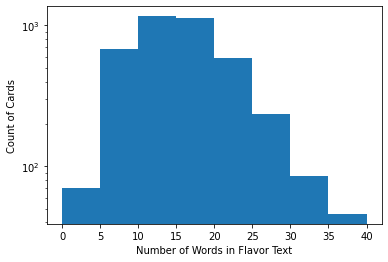

In [326]:
test_df = pd.DataFrame(data={'Text':flavor_test,'Label':label_test})
test_df['Word_Count'] = test_df.Text.apply(lambda x : len(x.split()))

bins = np.arange(0,45,5)
ax = plt.axes()
ax.hist(test_df['Word_Count'],bins=bins)
ax.set(ylabel='Count of Cards',xlabel='Number of Words in Flavor Text',yscale='log')


Now for each bin of flavor text word count, find the proportion of cards in that bin that are correctly classified:

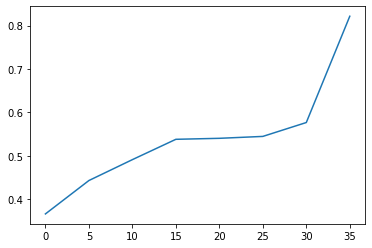

In [334]:
 # Put relevant information into a DataFrame for easier indexing
flavor_test_df = pd.DataFrame(data={'Text':flavor_test,'Label':label_test,'Word_Count':word_counts})
flavor_test_df[:]['Text']
counts_correct = np.zeros(len(bins)-1)
counts_all =   np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    sub_data = flavor_test_df[(flavor_test_df.Word_Count > bins[i]) & (flavor_test_df.Word_Count <= bins[i+1])][['Text','Label']]
    predicted = pipe.predict(sub_data.Text)
    counts_correct[i] = sum(predicted == sub_data.Label)
    counts_all[i] = sub_data.shape[0]

hit_rate = counts_correct / counts_all
plt.plot(bins[:-1],hit_rate)

In [328]:
max(word_counts)

53

TypeError: '<' not supported between instances of 'list' and 'int'